# ARIMA Model

## 1. Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('./Data/gld_price_data.csv', index_col='Date', parse_dates=True, usecols=['Date', 'SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'GLD' từ tập dữ liệu huấn luyện
y_train = train_data['GLD']
y_test = test_data['GLD']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'GLD'
X_train = train_data.drop(columns=['GLD'])
X_test = test_data.drop(columns=['GLD'])

Shape of data train (1832, 6)
Shape of data test (458, 6)


## 3. Dataset overview

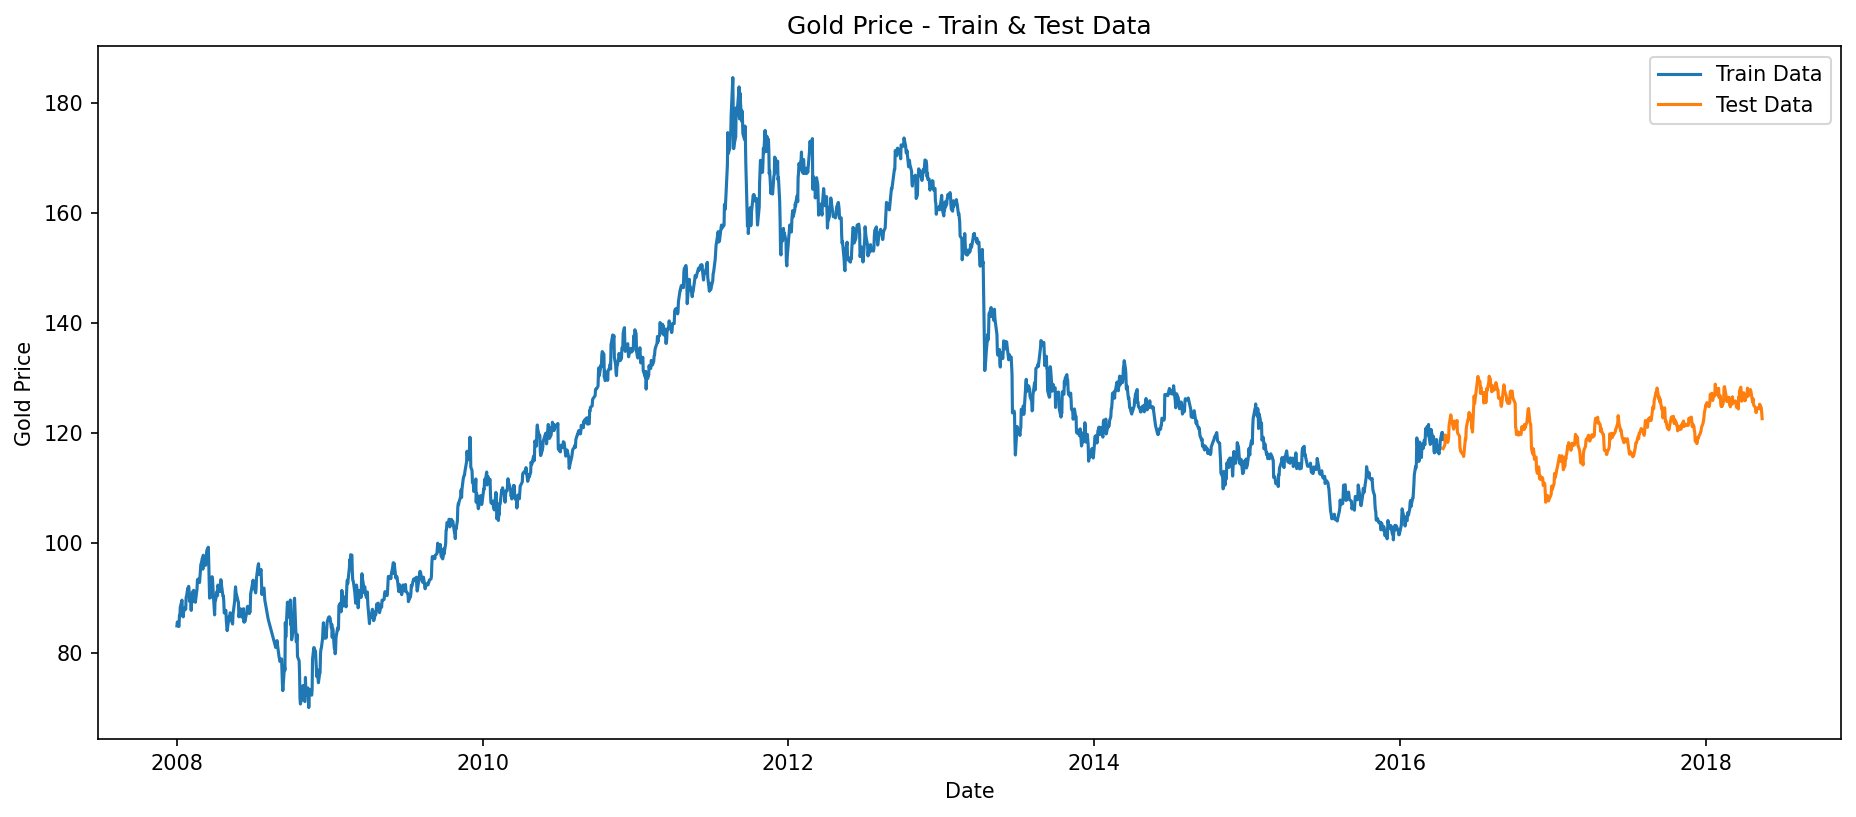

In [3]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['Date'], y_train, label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['Date'], y_test, label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

## 4. Thông tin chi tiết của tập Train và Test

In [4]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, 0 to 1831
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1832 non-null   datetime64[ns]
 1   SPX      1832 non-null   float64       
 2   GLD      1832 non-null   float64       
 3   USO      1832 non-null   float64       
 4   SLV      1832 non-null   float64       
 5   EUR/USD  1832 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 100.2 KB
<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, 1832 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     458 non-null    datetime64[ns]
 1   SPX      458 non-null    float64       
 2   GLD      458 non-null    float64       
 3   USO      458 non-null    float64       
 4   SLV      458 non-null    float64       
 5   EUR/USD  458 non-null    float64       
dtypes: datetim

### 5. Kiểm tra chuỗi thời gian có phải chuỗi dừng hay không

In [5]:
from statsmodels.tsa.stattools import adfuller
def check_adfuller(datasset):
  result = adfuller(datasset, autolag='AIC')
  print("1. ADF", result[0])
  print("2. P-Value: ", result[1])
  print("3. Num of Lags: ", result[2])
  print("4. Num of Observations Used for ADF Regression and Critical values calculation: ", result[3])
  print("5. Critical values: ")
  for key, val in result[4].items():
    print("\t", key, ": ", val)

In [6]:
check_adfuller(y_train)

1. ADF -1.7057562602510512
2. P-Value:  0.42814914548971794
3. Num of Lags:  1
4. Num of Observations Used for ADF Regression and Critical values calculation:  1830
5. Critical values: 
	 1% :  -3.433928413331545
	 5% :  -2.8631206697362663
	 10% :  -2.567611494520589


**Giải thích kết quả:**

Kết quả kiểm định Dickey-Fuller tăng cường (ADF) cho chuỗi thời gian giá vàng cho thấy:
1.   Giá trị thống kê ADF (-1.70575) không đủ âm để bác bỏ giả thuyết null về sự tồn tại của gốc đơn vị, cho thấy chuỗi có khả năng không dừng.
2.   P-Value (0.4281) cao hơn mức ngưỡng thông thường (0.05), không đủ để bác bỏ giả thuyết null, hỗ trợ kết luận chuỗi không dừng.
3.   Số độ trễ là 1 và số lượng quan sát là 1830 được sử dụng trong phân tích.
4.   Các giá trị tới hạn cho 1%, 5%, và 10% đều nhỏ hơn giá trị thống kê ADF, củng cố thêm bằng chứng rằng chuỗi không dừng.

**Kết luận:** Chuỗi thời gian giá vàng không dừng. Cần biến đổi chuỗi (ví dụ: lấy sai phân) trước khi áp dụng mô hình dự báo như ARIMA.

In [7]:
y_train_diff = y_train.diff().dropna()

# Hiển thị vài dòng đầu của chuỗi đã biến đổi
print(y_train_diff.head())

# Kiểm tra tính dừng của chuỗi đã biến đổi
check_adfuller(y_train_diff)

1    0.709999
2   -0.440003
3   -0.360000
4    2.010002
5   -0.229996
Name: GLD, dtype: float64
1. ADF -44.50652871715483
2. P-Value:  0.0
3. Num of Lags:  0
4. Num of Observations Used for ADF Regression and Critical values calculation:  1830
5. Critical values: 
	 1% :  -3.433928413331545
	 5% :  -2.8631206697362663
	 10% :  -2.567611494520589


**Giải thích kết quả:**

Kết quả kiểm định Dickey-Fuller tăng cường (ADF) cho chuỗi thời gian giá vàng cho thấy:
1.   Giá trị thống kê ADF (-44.50652871715483) rất âm và thấp hơn các giá trị tới hạn cho mọi mức ý nghĩa thống kê (1%, 5%, 10%), cho thấy chuỗi đã dừng.
2.   P-Value (0.0) rất nhỏ, cung cấp bằng chứng mạnh mẽ để bác bỏ giả thuyết null, khẳng định chuỗi đã dừng.
3.   Số độ trễ là 0 và số lượng quan sát là 1830 được sử dụng trong phân tích.

**Kết luận:** Chuỗi sai phân đã dừng, cho phép tiếp tục mô hình hóa và dự báo sử dụng mô hình ARIMA hoặc các mô hình chuỗi thời gian khác. Chuỗi đã dừng là điều kiện cần thiết cho việc mô hình hóa chuỗi thời gian hiệu quả.

### 6. Chọn mô hình phù hợp nhất

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
stepwise_fit = auto_arima(y_train_diff, start_p=0, start_q=0,
                      test='adf',       # sử dụng ADF test để xác định d
                      max_p=5, max_q=5, # giới hạn tối đa cho p và q
                      d=None,           # để None nếu muốn tự động xác định d
                      seasonal=False,   # đặt True nếu chuỗi thời gian là mùa vụ
                      stepwise=True,    # sử dụng phương pháp stepwise để tìm mô hình tối ưu
                      information_criterion='aic',  # sử dụng AIC để tìm mô hình tốt nhất
                      trace=True,       # in ra các bước tìm kiếm
                      error_action='ignore',
                      suppress_warnings=True,
                      random_state=42)        # số lượng mô hình khác nhau để thử
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7028.688, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7027.741, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7027.839, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7029.145, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7024.041, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7024.905, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7024.915, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7029.366, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7026.819, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7025.806, Time=0.30 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.009 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1831
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3509.021
Date:                Sun, 01 Dec 2024   AIC                           7024.041
Time:                        20:57:54   BIC                           7040.579
Sample:                             0   HQIC                          7030.141
                               - 1831                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9848      0.013    -74.036      0.000      -1.011      -0.959
ma.L1          0.9727      0.018     55.194      0.000       0.938       1.007
sigma2         2.7047      0.031     86.987      0.000       2.644       2.766
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):             16921.54
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 7. Khởi tạo và huấn luyện mô hình ARIMA

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Khởi tạo và train mô hình
model = ARIMA(y_train_diff, order=stepwise_fit.order)  # ARIMA(1,0,1)

fit_model = model.fit()

C:\Users\HHunTTer\.conda\envs\lab-data-mining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HHunTTer\.conda\envs\lab-data-mining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\HHunTTer\.conda\envs\lab-data-mining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


### 7. Dự đoán và tính toán các độ đo

In [10]:
# Dự đoán
predictions_diff = fit_model.forecast(steps=test_data.shape[0])

# Khôi phục giá trị gốc từ sai phân (nếu đã thực hiện sai phân)
if adfuller(y_train)[1] > 0.05:
    predictions = y_train.iloc[-1] + predictions_diff.cumsum()
else:
    predictions = predictions_diff

y_true = y_test.values
y_pred = predictions  # Sử dụng giá trị đã được khôi phục từ sai phân

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# Accuracy
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}%")

MAE: 4.101201489814583
MAPE: 3.444709071524884%
RMSE: 5.148359355810325
Accuracy: 96.55529092847512%


C:\Users\HHunTTer\.conda\envs\lab-data-mining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HHunTTer\.conda\envs\lab-data-mining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### 8. Biểu đồ dự đoán của mô hình

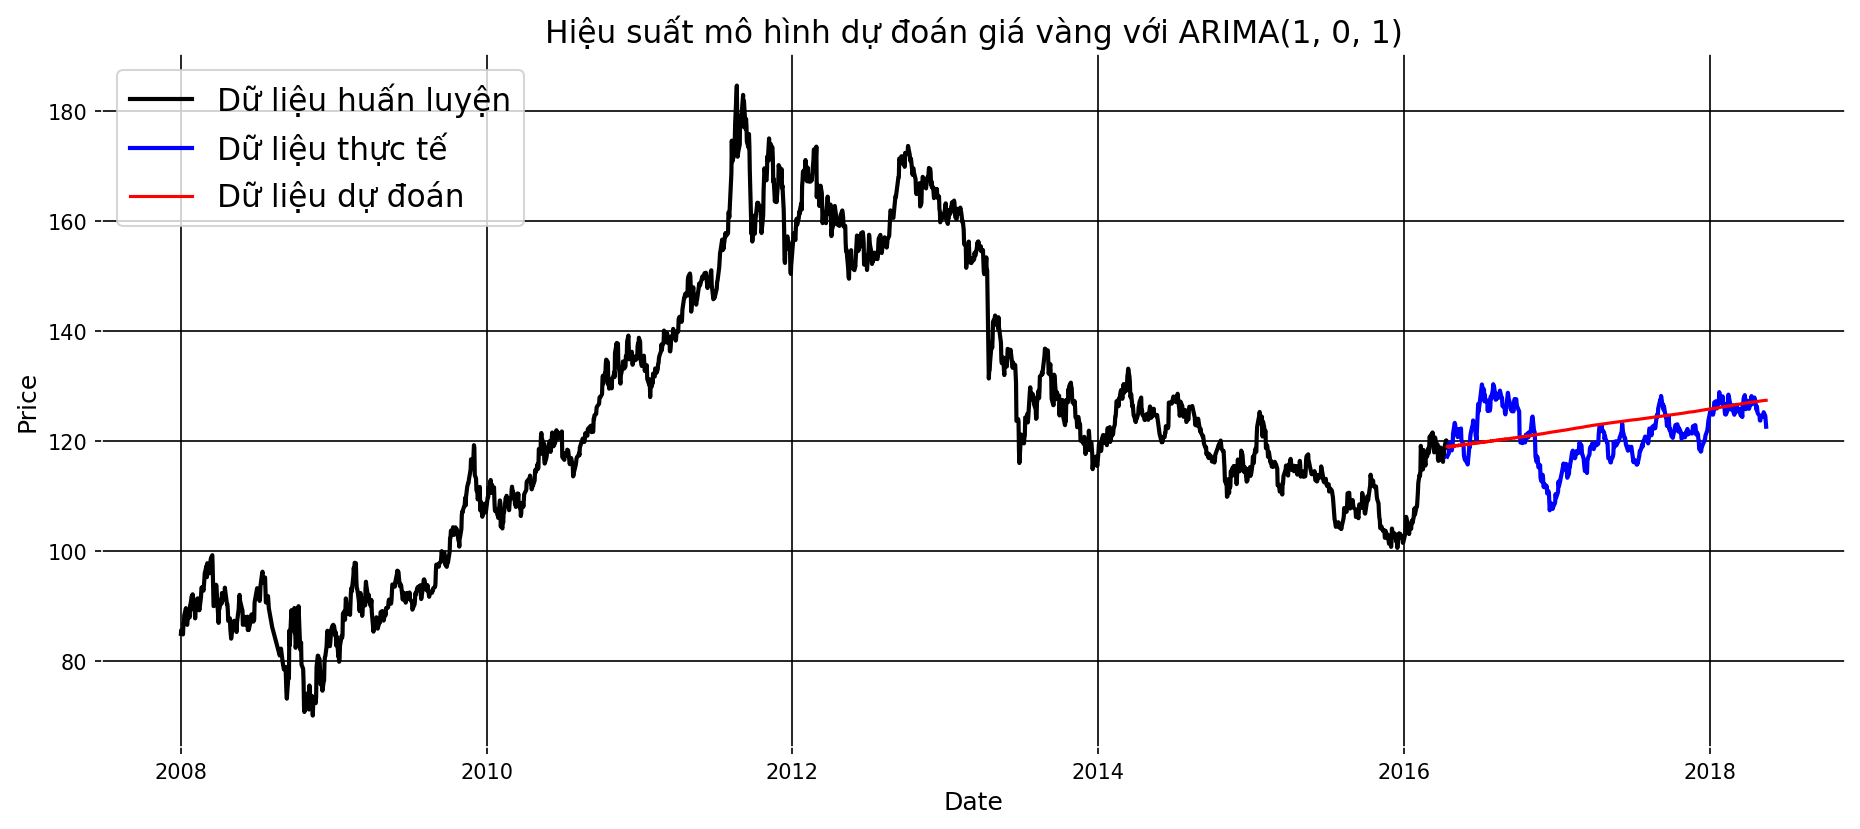

In [11]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes', edgecolor='white')

# Vẽ dữ liệu huấn luyện
plt.plot(train_data['Date'], y_train.values, color='black', lw=2)

# Vẽ dữ liệu thực tế của tập kiểm tra
plt.plot(test_data['Date'], y_test, color='blue', lw=2)

# Vẽ dữ liệu dự đoán từ mô hình ETS
plt.plot(test_data['Date'], predictions, label='Dữ liệu dự đoán', color='red')

# Tiêu đề và nhãn
plt.title(f'Hiệu suất mô hình dự đoán giá vàng với ARIMA{stepwise_fit.order}', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Chú thích
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='black')
plt.show()